# Part 3 : Mitigate Bias, Train another unbiased Model and Put in the Model Registry

<a id='aup-overview'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 0 : Overview, Architecture and Data Exploration](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
* **[Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)**
  * **[Architecture](#train2)**
  * **[Develop a second model](#second-model)**
  * **[Analyze the Second Model for Bias](#analyze-second-model)**
  * **[View Results of Clarify Bias Detection Job](#view-second-clarify-job)**
  * **[Configure and Run Clarify Explainability Job](#explainability)**
  * **[Create Model Package for the Second Trained Model](#model-package)**
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
* [Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)

이 노트북에서는 Clarify를 사용하여 편향을 감지하고, SMOTE를 사용하여 이를 완화하고, 다른 모델을 훈련하고, 그 과정에서 생성된 모든 아티팩트 계보(데이터, 코드 및 모델 메타데이터)와 함께 모델 레지스트리에 배치하는 방법을 설명합니다.

### Import libraries

In [1]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.xgboost.estimator import XGBoost

from model_package_src.inference_specification import InferenceSpecification

%matplotlib inline

### Load stored variables

이전에 이 노트북을 실행한 경우, AWS에서 생성한 리소스를 재사용할 수 있습니다. 아래 셀을 실행하여 이전에 생성된 변수를 로드합니다. 기존 변수의 출력물이 표시되어야 합니다. 인쇄된 내용이 보이지 않으면 노트북을 처음 실행한 것일 수 있습니다.

In [4]:
%store -r
%store

Stored variables and their in-db values:
bucket                              -> 'sagemaker-us-east-2-143656149352'
claims_fg_name                      -> 'fraud-detect-demo-claims'
claims_table                        -> 'fraud-detect-demo-claims-1629447691'
clarify_bias_job_1_name             -> 'Clarify-Bias-2021-08-20-08-46-43-569'
col_order                           -> ['fraud', 'customer_gender_female', 'customer_gend
customers_fg_name                   -> 'fraud-detect-demo-customers'
customers_table                     -> 'fraud-detect-demo-customers-1629447692'
database_name                       -> 'sagemaker_featurestore'
hyperparameters                     -> {'max_depth': '3', 'eta': '0.2', 'objective': 'bin
model_1_name                        -> 'fraud-detect-demo-xgboost-pre-smote'
mpg_name                            -> 'fraud-detect-demo'
prefix                              -> 'fraud-detect-demo'
test_data_uri                       -> 's3://sagemaker-us-east-2-14365614935

**<font color='red'>Important</font>: StoreMagic 명령을 사용하여 변수를 검색하려면 이전 노트북을 실행해야 합니다.**

### Set region, boto3 and SageMaker SDK variables

In [5]:
#You can change this to a region of your choice
import sagemaker
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-2


In [6]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client("sts").get_caller_identity()["Account"]

In [7]:
# variables used for parameterizing the notebook run
model_2_name = f"{prefix}-xgboost-post-smote"

train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"
bias_report_2_output_path = f"s3://{bucket}/{prefix}/clarify-output/bias-2"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

<a id ='train2'> </a>
## Architecture for this ML Lifecycle Stage : Train, Check Bias, Tune, Record Lineage, Register Model
[overview](#aup-overview)
___

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

<a id='second-model'></a>

## Develop a second model

[overview](#aup-overview)
___

이 두 번째 모델에서는 SMOTE를 사용하여 데이터셋의 성별 불균형을 수정하고 XGBoost를 사용하여 다른 모델을 훈련합니다. 이 모델은 또한 레지스트리에 저장되고 최종적으로 배포가 승인됩니다.

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [9]:
train

fraud  customer_gender_female  customer_gender_male  policy_state_or  \
0         0                       1                     0                0   
1         0                       1                     0                0   
2         0                       0                     1                0   
3         0                       1                     0                0   
4         0                       0                     1                0   
...     ...                     ...                   ...              ...   
3995      0                       0                     1                0   
3996      0                       1                     0                0   
3997      0                       0                     1                0   
3998      0                       0                     1                0   
3999      0                       0                     1                0   

      injury_claim  policy_state_ca  collision_type_na  \
0              0.0                1                  0   
1              0.0                0                  1   
2          16000.0                1                  0   
3              0.0                1                  0   
4              0.0                0                  0   
...            ...              ...                ...   
3995           0.0                0                  0   
3996           0.0                1                  0   
3997           0.0                1                  0   
3998           0.0                1                  0   
3999           0.0                0                  0   

      police_report_available  incident_month  policy_state_nv  ...  \
0                           0               1                0  ...   
1                           0              12                0  ...   
2                           1               9                0  ...   
3                           0               1                0  ...   
4                           0               8                1  ...   
...                       ...             ...              ...  ...   
3995                        0               8                0  ...   
3996                        1              12                0  ...   
3997                        0               7                0  ...   
3998                        0               8                0  ...   
3999                        0               2                0  ...   

      incident_severity  policy_deductable  authorities_contacted_police  \
0                     0                750                             0   
1                     1                750                             1   
2                     1                750                             1   
3                     0                750                             0   
4                     0                750                             0   
...                 ...                ...                           ...   
3995                  0                750                             0   
3996                  0                750                             1   
3997                  1                750                             1   
3998                  0                750                             0   
3999                  0                750                             1   

      incident_type_collision  authorities_contacted_ambulance  \
0                           1                                0   
1                           0                                0   
2                           1                                0   
3                           1                                0   
4                           1                                0   
...                       ...                              ...   
3995                        1                                0   
3996                        1                                0   
3997        

In [10]:
test

fraud  customer_gender_female  customer_gender_male  policy_state_or  \
0        0                       0                     1                0   
1        0                       0                     1                1   
2        0                       0                     1                0   
3        0                       0                     1                0   
4        1                       0                     1                0   
..     ...                     ...                   ...              ...   
995      0                       0                     1                0   
996      0                       0                     1                0   
997      0                       0                     1                0   
998      1                       0                     1                0   
999      0                       0                     1                0   

     injury_claim  policy_state_ca  collision_type_na  \
0             0.0                1                  0   
1             0.0                0                  0   
2             0.0                1                  0   
3             0.0                0                  0   
4             0.0                0                  0   
..            ...              ...                ...   
995           0.0                1                  1   
996           0.0                1                  0   
997           0.0                0                  0   
998           0.0                1                  0   
999           0.0                1                  0   

     police_report_available  incident_month  policy_state_nv  ...  \
0                          1               1                0  ...   
1                          0               4                0  ...   
2                          0              12                0  ...   
3                          1               8                0  ...   
4                          0               1                0  ...   
..                       ...             ...              ...  ...   
995                        0              12                0  ...   
996                        0               6                0  ...   
997                        1               2                0  ...   
998                        0               4                0  ...   
999                        1               3                0  ...   

     incident_severity  policy_deductable  authorities_contacted_police  \
0                    0                750                             1   
1                    0                750                             0   
2                    0                750                             0   
3                    1                750                             1   
4                    0                750                             0   
..                 ...                ...                           ...   
995                  1                750                             1   
996                  2                750                             0   
997                  1                750                             1   
998                  1                750                             1   
999                  0                750                             1   

     incident_type_collision  authorities_contacted_ambulance  \
0                          1                                0   
1                          1                                0   
2                          1                                0   
3                          1                                0   
4                          1                                0   
..                       ...                              ...   
995                        0                                0   
996                        1                                0   
997                        1                                0   
998

<a id='smote'></a>
### Resolve class imbalance using SMOTE

불균형을 처리하기 위해 [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf)를 사용하여 소수 클래스를 오버샘플링 (즉, 업샘플링) 할 수 있습니다. imbalanced-learn 모듈을 설치한 후 SMOTE를 임포트할 때 ImportError가 발생하면 커널을 다시 시작하십시오.

#### Gender balance before SMOTE

In [11]:
gender = train['customer_gender_female']
gender.value_counts()

0    2788
1    1212
Name: customer_gender_female, dtype: int64

#### Gender balance after SMOTE

In [12]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled['customer_gender_female'].value_counts()

0    2788
1    2788
Name: customer_gender_female, dtype: int64

### Train new model


In [13]:
train_data_upsampled.to_csv("data/upsampled_train.csv", index=False)
s3_client.upload_file(
    Filename="data/upsampled_train.csv",
    Bucket=bucket,
    Key=f"{prefix}/data/train/upsampled/train.csv",
)

In [14]:
xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

In [15]:
if 'training_job_2_name' not in locals():
    
    xgb_estimator.fit(inputs = {'train': train_data_upsampled_s3_path})
    training_job_2_name = xgb_estimator.latest_training_job.job_name
    %store training_job_2_name
    
else:
    
    print(f'Using previous training job: {training_job_2_name}')

2021-08-20 09:11:11 Starting - Starting the training job...
2021-08-20 09:11:34 Starting - Launching requested ML instancesProfilerReport-1629450670: InProgress
......
2021-08-20 09:12:34 Starting - Preparing the instances for training.........
2021-08-20 09:14:05 Downloading - Downloading input data
2021-08-20 09:14:05 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for xgboost-starter-script: filename=xgboost_sta

### Register artifacts

In [16]:
training_job_2_info = sagemaker_boto_client.describe_training_job(
    TrainingJobName=training_job_2_name
)

#### Code artifact

In [17]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info["HyperParameters"]["sagemaker_submit_directory"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=code_s3_uri, sagemaker_session=sagemaker_session
    )
)

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingScript",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

Create artifact arn:aws:sagemaker:us-east-2:143656149352:artifact/6cbfc88a3e9cd2260a24bb03bdb9055a: SUCCESSFUL


#### Training data artifact

In [18]:
training_data_s3_uri = training_job_2_info['InputDataConfig'][0]['DataSource']['S3DataSource']['S3Uri']

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    training_data_artifact = list_response[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-2:143656149352:artifact/a9e224538285546a84b1e7f1ecc56792


#### Model artifact

In [19]:
trained_model_s3_uri = training_job_2_info["ModelArtifacts"]["S3ModelArtifacts"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    model_artifact = list_response[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-2:143656149352:artifact/8b2c45b7f63eea5e60155039e864a68c


### Set artifact associations

In [20]:
trial_component = sagemaker_boto_client.describe_trial_component(
    TrialComponentName=training_job_2_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

#### Input artifacts

In [21]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-2:143656149352:experiment-trial-component/sagemaker-xgboost-2021-08-20-09-11-10-641-aws-training-job and arn:aws:sagemaker:us-east-2:143656149352:artifact/6cbfc88a3e9cd2260a24bb03bdb9055a: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-2:143656149352:experiment-trial-component/sagemaker-xgboost-2021-08-20-09-11-10-641-aws-training-job and arn:aws:sagemaker:us-east-2:143656149352:artifact/a9e224538285546a84b1e7f1ecc56792.



#### Output artifacts

In [22]:
output_artifacts = [model_artifact]

for artifact_arn in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Association already exists between arn:aws:sagemaker:us-east-2:143656149352:experiment-trial-component/sagemaker-xgboost-2021-08-20-09-11-10-641-aws-training-job and arn:aws:sagemaker:us-east-2:143656149352:artifact/a9e224538285546a84b1e7f1ecc56792.



<pre>

</pre>

<a id ='analyze-second-model'></a>
## Analyze the second model for bias and explainability

[overview](#aup-overview)
___
Amazon SageMaker Clarify는 머신 러닝 (ML) 모델이 예측을 수행하는 방법을 설명하는 데 도움이 되는 도구를 제공합니다. 이러한 도구는 ML 모델러와 개발자 및 기타 내부 이해 관계자가 배포 전에 모델 특성을 전체적으로 이해하고 배포 후 모델에서 제공하는 예측을 디버그하는 데 도움이 될 수 있습니다. ML 모델이 예측에 어떻게 도달하는지에 대한 투명성은 모델 예측을 기반으로 결정을 받아들일 경우, 이를 신뢰해야 하는 소비자 및 규제 기관에게도 중요합니다. SageMaker Clarify는 모델에 구애받지 않는(model-agnostic) 피쳐 속성 접근 방식을 사용합니다. 모델 훈련 후 예측을 수행 한 이유를 이해하고 추론 중에 인스턴스 별 설명을 제공하는 데 사용할 수 있습니다. 구현에는 각 피쳐에 특정 예측에 대한 중요도 값을 할당하는 협동 게임 이론 분야의 Shapley 값 개념을 기반으로 확장 가능하고(scalable) 효율적인 SHAP 구현([see paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)이 포함됩니다. 

### Create model from estimator

In [23]:
model_matches = sagemaker_boto_client.list_models(NameContains=model_2_name)['Models']

if not model_matches:
    
    model_2 = sagemaker_session.create_model_from_job(
        name=model_2_name,
        training_job_name=training_job_2_info['TrainingJobName'],
        role=sagemaker_role,
        image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
    %store model_2_name
    
else:
    
    print(f"Model {model_2_name} already exists.")

Stored 'model_2_name' (str)


<a id='bias-v1'></a>
### Check for data set bias and model bias

SageMaker를 사용하면 사전 훈련 및 사후 훈련 편향을 확인할 수 있습니다. 사전 훈련 metric은 해당 데이터의 기존 metric을 보여주는 반면, 사후 훈련 metric은 모델의 예측에서 편향을 보여줍니다. SageMaker SDK를 사용하여 편향을 확인하려는 그룹과 표시할 metric을 지정할 수 있습니다.

전체 Clarify 작업을 실행하려면, 아래 셀에서 코드의 주석 처리를 제거해야 합니다. 작업을 실행하는 데 약 15분 정도 소요됩니다. 시간을 절약하려면 편향 작업이 실행되지 않은 경우 미리 생성된 결과를 로드한 후, 다음 셀에서 결과를 볼 수 있습니다.

In [24]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

# # un-comment the code below to run the whole job

# if 'clarify_bias_job_2_name' not in locals():

#     clarify_processor.run_bias(
#         data_config=bias_data_config,
#         bias_config=bias_config,
#         model_config=model_config,
#         model_predicted_label_config=predictions_config,
#         pre_training_methods='all',
#         post_training_methods='all')

#     clarify_bias_job_2_name = clarify_processor.latest_job.name
#     %store clarify_bias_job_2_name

# else:
#     print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')

<a id ='view-second-clarify-job'></a>
## View results of Clarify job
[overview](#aup-overview)
___

데이터셋 또는 모델에서 Clarify를 실행하는 데 15분 정도 걸릴 수 있습니다. 작업을 실행할 시간이 없는 경우, 이 데모에 포함된 미리 생성된 결과를 볼 수 있습니다. 그렇지 않으면 위의 셀에서 코드 주석 처리를 제거하여 작업을 실행할 수 있습니다.

In [25]:
if "clarify_bias_job_2_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/bias-2/analysis.json",
        Filename="clarify_output/bias_2/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/bias_1/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

with open("clarify_output/bias_2/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

Loading pre-generated analysis file...

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.394
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


<a id ='explainability' ></a>
## Configure and run explainability job
[overview](#aup-overview)
___
전체 Clarify 작업을 실행하려면, 아래 셀에서 코드의 주석 처리를 제거해야 합니다. 작업을 실행하는 데 약 15분 정도 소요됩니다. 시간을 절약하려면 편향 작업이 실행되지 않은 경우 미리 생성된 결과를 로드한 후, 다음 셀에서 결과를 볼 수 있습니다.

In [26]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()], num_samples=100, agg_method="mean_abs"
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

# un-comment the code below to run the whole job

# if 'clarify_expl_job_name' not in locals():

#     clarify_processor.run_explainability(
#         data_config=explainability_data_config,
#         model_config=model_config,
#         explainability_config=shap_config)

#     clarify_expl_job_name = clarify_processor.latest_job.name
#     %store clarify_expl_job_name

# else:
#     print(f'Clarify job {clarify_expl_job_name} has already run successfully.')

### View Clarify explainability results (shortcut)
데이터셋 또는 모델에서 Clarify를 실행하는 데 15분 정도 걸릴 수 있습니다. 작업을 실행할 시간이 없는 경우, 이 데모에 포함된 미리 생성된 결과를 볼 수 있습니다. 그렇지 않으면 위의 셀에서 코드 주석 처리를 제거하여 작업을 실행할 수 있습니다.

Loading pre-generated analysis file...



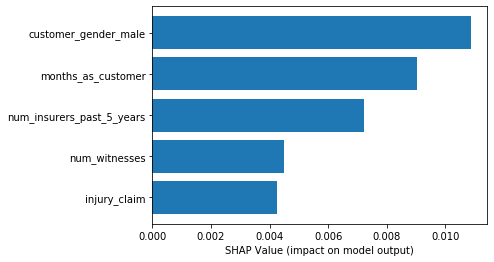

In [27]:
if "clarify_expl_job_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/analysis.json",
        Filename="clarify_output/explainability/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/explainability/analysis.json", "r") as f:
    analysis_result = json.load(f)

shap_values = pd.DataFrame(analysis_result["explanations"]["kernel_shap"]["label0"])
importances = shap_values["global_shap_values"].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()
ax.set_xlabel("SHAP Value (impact on model output)");

자동 생성된 SageMaker Clarify 보고서를 보려면, 다음 코드를 실행하고 출력 링크를 사용하여 보고서를 엽니다.

In [28]:
from IPython.display import FileLink, FileLinks

display(
    "Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf")
)

'Click link below to view the SageMaker Clarify report'

/root/sagemaker-studio-end-to-end/clarify_output/report.pdf

### What is SHAP?

SHAP은 이 솔루션에서 설명을 계산하는 데 사용되는 방법입니다. 단일 feature
permutation과 같은 다른 feature attribution 방법과 달리 SHAP는 가능한 모든 피쳐 조합을 조사하여 단일 피쳐의 효과를 분리하려고 합니다.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017)는 SHapley Additive exPlanations를 나타냅니다. 'Shapley'는 설명을 만드는 데 사용되는 [Shapley
values](https://en.wikipedia.org/wiki/Shapley_value)라는 게임 이론 개념과 관련이 있습니다. Shapley 값은 가능한 모든 '연합'을 고려할 때 각 '플레이어'의 한계 기여도를 나타냅니다. 머신 러닝 컨텍스트에서 이를 사용하여 Shapley 값은 가능한 모든 피쳐 셋을 고려할 때 각 피쳐의 한계 기여도를 설명합니다. 'Additive'는 이러한 Shapley 값을 합하여 최종 모델 예측을 제공할 수 있다는 사실과 관련이 있습니다.

예를 들어 기본 신용 불이행(credit default risk) 위험도 10%로 시작할 수 있습니다. 피쳐 집합이 주어지면, 각 피쳐에 대한 Shapley 값을 계산할 수 있습니다. 모든 Shapley 값을 합하면 +30%의 누적 값을 얻을 수 있습니다. 따라서 동일한 피쳐 세트가 주어지면 모델이 신용 불이행 위험 도 40% (즉, 10% + 30%)를 반환할 것으로 예상합니다.

<a id='model-package' ></a>
## Create Model Package for the Second Trained Model
[overview](#aup-overview)
___

#### Create and upload second model metrics report

In [29]:
model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_2_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = (
    f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
)
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

#### Define inference specification

In [30]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_2_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

#### Define model metrics

In [31]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{explainability_output_path}/analysis.json",
        }
    },
}

#### Register second model package to Model Package Group

In [32]:
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect insurance fraud with SMOTE.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_boto_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response["ModelPackageArn"]
%store mp2_arn

Stored 'mp2_arn' (str)


#### Check status of model package creation

In [33]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp2_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp2_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


### View both models in the registry

In [34]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 2,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-2:143656149352:model-package/fraud-detect-demo/2',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 8, 20, 9, 15, 24, 963000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-2:143656149352:model-package/fraud-detect-demo/1',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud.',
  'CreationTime': datetime.datetime(2021, 8, 20, 8, 43, 21, 26000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'}]

___

### Next Notebook: [Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)